In [611]:
# block size - context length
BLOCK_SIZE = 3
words = open('../data/names.txt', 'r').read().splitlines()

In [612]:
len(words)

32033

In [613]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [614]:
import torch
import torch.nn.functional as F

In [615]:
X, Y = [] , []

for w in words:
    context = [0] * BLOCK_SIZE
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [616]:
def build_dataset(words):
    X, Y = [] , []

    for w in words:
        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
    
    

In [617]:
# shuffling the words
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



In [618]:
# create the parameters of the model

# embedding model / lookup table that converts
# the input (characters) into vectors
# we can assum that the dimension is 2

C = torch.randn((27, 10))
# emb = C[X]
# emb.shape

In [619]:
W1 = torch.randn((30, 200)) # 2 embeddings * 3 = row vectors of length 6
b1 = torch.randn(200) # 100 neurons and 100 biases

In [620]:
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # note the broadcasting semantics

# 32 x 100
#      100 - right aligned, broadcast along the 0th dimension

In [621]:
# h

In [622]:
# h.shape


In [623]:
W2 = torch.randn((200, 27))
b2 = torch.randn(27) 

In [624]:
parameters = [C, W1, b1, W2, b2]

In [625]:
sum(p.nelement() for p in parameters)

11897

In [626]:
for p in parameters:
    p.requires_grad = True

In [627]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre
lrs


tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [628]:
lri = []
stepi = []
lossi = []

In [629]:
# select some portion of the dataset (minibatch)

for i in range(200000):
    # sample 32 numbers from the example
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad = None

    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())


print(loss.item())

2.18898344039917


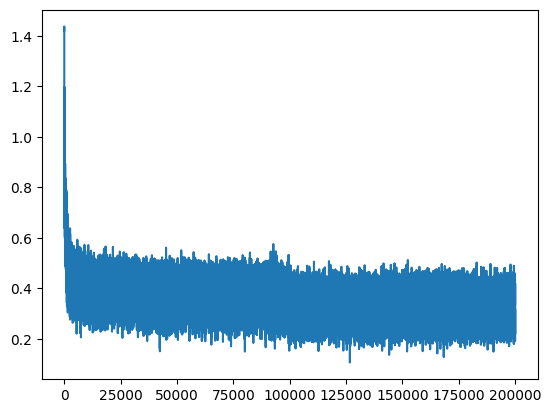

In [630]:
import matplotlib.pyplot as plt
plt.plot(stepi, lossi)

In [610]:
# full loss
embed = C[Xdev]
h = torch.tanh(embed.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
full_loss = F.cross_entropy(logits, Ydev)
full_loss.item()



2.219330310821533

In [ ]:
# 80%, 10%, 10% split

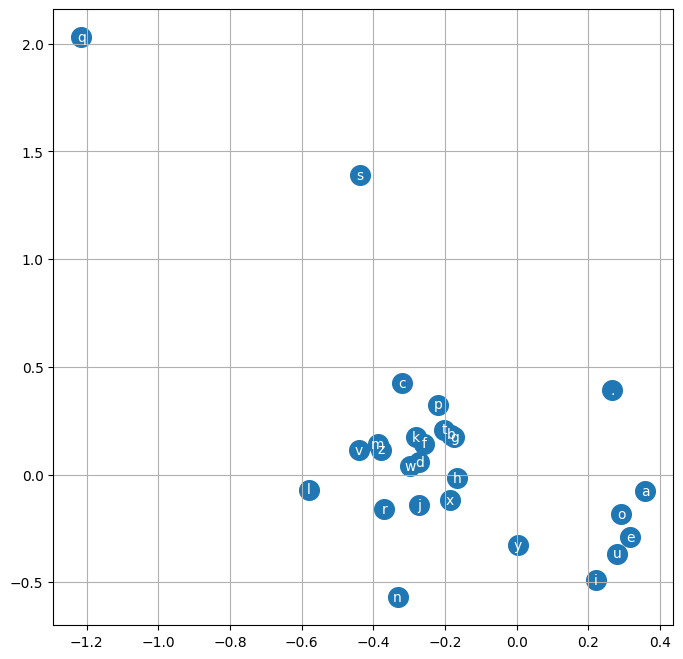

In [541]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')